# Performance

Perfomance (also die Geschwindigkeit der Ausführung) ist bei realen (wissenschaftlichen) Problemen schnell ein wichtiger Aspekt um das gegebene Problem gut und schnell zu lösen.

**Einflussfaktoren**

- Algorithmus
- *Implementation*
- Betriebssytem und Programmiersprache
- Hardware


*Avoid premature optimization*

### Beispiel: Mandelbrot

Die Mandelbrot-Menge ist die Menge von Punkten $c \in \mathbb{C}$ bei denen die Folge $(z_n)_n$, die durch
$$ z_0:=c, \qquad z_{n+1} = z_n^2 +c, \quad n \in \mathbb{N}$$
definiert ist, beschränkt ist.

Die zu schreibende Funktion gibt zu jedem $c=x+iy$ die Anzahl der Iterationsschritte zurück bis die Folge divergiert und das bilden wir dann auf eine Farbe mittels `imshow`.  

In [1]:
from numpy import zeros, copy

def mandel_simpleloop(C):
    Z = copy(C)
    niter = zeros(C.shape)
    it_max = 40

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            for k in range(it_max):
                Z[i, j] = Z[i, j]**2 + C[i, j]
                if abs(Z[i, j]) > 2.5:
                    break
            niter[i, j] = k
    return niter

mandel_simpleloop  21.675 s


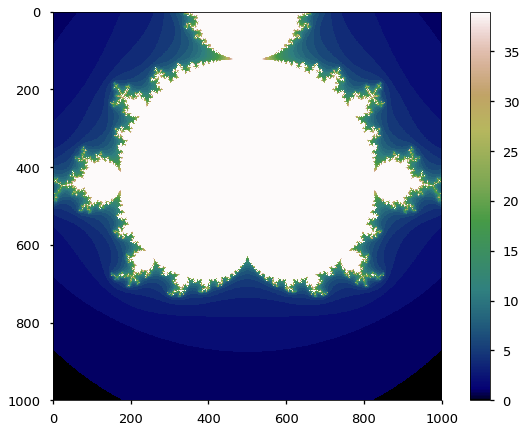

In [1]:
from numpy import ogrid

N = 1000
X, Y = ogrid[-1:1:N*1j, -1:1:N*1j]
C = X + 1j*Y

from time import time

tic = time()
mandel = mandel_simpleloop(C)
print("mandel_simpleloop {:7.3f} s".format(time() - tic))

import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

plt.imshow(mandel, cmap='gist_earth')
plt.colorbar()
plt.show()

Soweit so gut. Schauen wir uns doch mal an *was* oder vielmehr *wo* das Programm langsam ist.

## Profiler
Tool um Performance-Engstellen (*bottlenecks*) und Fehler (Bugs) herauszufinden.

###  cProfile

* Anzahl Funktionsaufrufe
* Zeit pro Funktionsaufruf und gesamt durch die jeweilige Funktion

``` python
python -m cProfile -o <output.txt>  <script.py>
```

In [1]:
%%bash
python -m cProfile -o mandelprofile.txt ../mandel.py

mandel_simpleloop  30.883 s


Dann können wir uns die Datei direkt oder mit dem Modul `pstats` ansehen.

``` python
pstats.Stats(filename)
```

- sort_stats('spalte'): sortiert nach der entsprechenden Spalte
- print_stats(anzzeilen): gibt die ersten anzzeilen Zeilen aus.

In [1]:
import pstats
p = pstats.Stats('mandelprofile.txt')
p.strip_dirs().sort_stats('time').print_stats(20)

Wed Sep  6 14:10:03 2017    mandelprofile.txt

         18334443 function calls (18332519 primitive calls) in 31.137 seconds

   Ordered by: internal time
   List reduced from 802 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   29.083   29.083   30.882   30.882 mandel.py:7(mandel_simpleloop)
 18132642    1.789    0.000    1.789    0.000 {built-in method builtins.abs}
     3943    0.042    0.000    0.127    0.000 <frozen importlib._bootstrap_external>:1223(find_spec)
    16/15    0.020    0.001    0.031    0.002 {built-in method _imp.create_dynamic}
      108    0.019    0.000    0.019    0.000 {built-in method marshal.loads}
    19773    0.018    0.000    0.048    0.000 <frozen importlib._bootstrap_external>:57(_path_join)
    19773    0.018    0.000    0.026    0.000 <frozen importlib._bootstrap_external>:59(<listcomp>)
     4231    0.015    0.000    0.015    0.000 {built-in method posix.stat}
        1    0.012    0.0

Alternativ in spyder:
- *F10*: Startet das gegebene Programm im grafischen Profiler.
- Der Profiler listet alle Funktionen in ihrer Hierarchie auf und zeigt deren Zeitverbrauch.


Das ganze hilft uns leider noch relativ wenig.. wir wissen ja schon, dass mandelbox_simpleloop die ganze Arbeit macht, aber wo?

### line profiler
Der *line_profiler*  kann exakt sagen, welche Zeilen wieviel Zeit verbraucht haben. 

Dafür benutzt man den ```@profile``` decorator:

``` python
@profile
def function ():
    ...
```

und ruft dann (ausserhalb von spyder) den eigentlichen Profiler auf:

``` bash
kernprof -l -v <file.py>
``` 


In [1]:
%%bash
kernprof -l -v ../mandel.py

mandel_simpleloop 110.937 s
Wrote profile results to mandel.py.lprof
Timer unit: 1e-06 s

Total time: 72.6041 s
File: ../mandel.py
Function: mandel_simpleloop at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           @profile
     8                                           def mandel_simpleloop(C):
     9         1         9407   9407.0      0.0      Z = copy(C)
    10         1           24     24.0      0.0      niter = zeros(Z.shape)
    11         1            1      1.0      0.0      it_max = 40
    12                                           
    13      1001          753      0.8      0.0      for i in range(Z.shape[0]):
    14   1001000       733065      0.7      1.0          for j in range(Z.shape[0]):
    15  18500474     13872294      0.7     19.1              for k in range(it_max):
    16  18132566     34670714      1.9     47.8                  Z[i, j] = Z[i, j]**2 + C[i, j]
    17  18132566     21787613  

Hieraus lernen wir jetzt, dass die Zeilen in der Schleife die meiste Zeit brauchen. Was könnten wir besser machen?

1. Es sind lauter Indizierungen vorhanden die unnötig sind. Wir können temporäre Variablen erzeugen in der Schleife

In [1]:
def mandel_betterloop(C):
    niter = zeros(C.shape)
    it_max = 40

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            cij = C[i, j]
            zij = cij
            for k in range(it_max):
                zij = zij**2 + cij
                if abs(zij) > 2.5:
                    break
            niter[i, j] = k
    return niter

tic = time()
mandel = mandel_betterloop(C)
print("mandel_betterloop {:7.3f} s".format(time()-tic))

mandel_betterloop   1.323 s


In [1]:
%%bash
kernprof -l -v ../mandelbetter.py

mandel_betterloop  97.710 s
Wrote profile results to mandelbetter.py.lprof
Timer unit: 1e-06 s

Total time: 57.4884 s
File: ../mandelbetter.py
Function: mandel_betterloop at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           @profile
     8                                           def mandel_betterloop(C):
     9         1           27     27.0      0.0      niter = zeros(C.shape)
    10         1            1      1.0      0.0      it_max = 40
    11                                           
    12      1001          731      0.7      0.0      for i in range(C.shape[0]):
    13   1001000       791014      0.8      1.4          for j in range(C.shape[1]):
    14   1000000      1062560      1.1      1.8              cij = C[i, j]
    15   1000000       719439      0.7      1.3              zij = cij
    16  18500474     13832841      0.7     24.1              for k in range(it_max):
    17  18132566     21675567     

Das ist deutlich besser auch zu sehen an den Zeilen wo indiziert wird.

Wie kriegt man es nun noch schneller? Eine weitere Möglichkeit sind...

## NumPy - tricks

NumPy/SciPy ist durchaus gut optimiert und schnell. Man sollte jedoch Schleifen über Arrays vermeiden und stattdessen *slices* benutzen. Das ist nicht nur schneller sondern auch kürzer und manchmal auch besser lesbar (und man braucht keine Indizes). Aus dem Gleichen Grund ist allgemein das Nutzen von Array-Operationen besser.

*Warum for-loops langsam sind*:
Hier muss Python jedesmal unter anderen die Typen prüfen, was einen grossen Overhead bedeutet. Wenn man NumPy mit slices aufruft wird intern direkt auf den Speicher zugegriffen.

Also:

**Array-Operationen und Slicing > Loops und Indexing**

*Beispiel:* 1D-Distanz

In [1]:
from numpy.random import randn
from numpy import zeros

a = randn(1000000)
d = zeros(a.shape[0]-1)

In [1]:
%%timeit
for i in range(len(d)):
    d[i] = a[i] - a[i+1]

1 loop, best of 3: 466 ms per loop


In [1]:
%%timeit
d[:] = a[:-1] - a[1:]

1000 loops, best of 3: 1.57 ms per loop


Das macht auch unsere Mandelbrot-Funktion deutlich besser: Wir nutzen einfach Arrays als ganzes

In [1]:
def mandel_array(C):
    Z = C
    niter = zeros(C.shape)
    it_max = 40

    for k in range(it_max):
        Z = Z**2 + C
        niter += (abs(Z) < 2.5)
    return niter

tic = time()
mandel = mandel_array(C)
print("mandel_array {:7.3f} s".format(time() - tic))

/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in square
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in square
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in absolute
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


mandel_array   0.904 s


Allerdings machen wir hier auch einiges unnötig zuviel: In jedem Punkt werden bis `it_max` alle Folgen-elemente ausgerechnet. Vielleicht können wir sowohl den Nachteil der Loops umgehen als auch nicht unnötig Operationen durchführen?
Dafür ein Blick auf wie Python mit Code umgeht..

## Just In Time compiler - numba

Python *interpretiert* den Code zur Laufzeit und muss dabei dynamisch die Typen erkennen, die benötigt werden. Das erzeugt signifikanten Overhead (siehe auch oben bzgl. *slices*). 

**J**ust **I**n **T**ime (JIT) compiler erkennen beim erstmaligen Aufruf möglichst die Typen und kompilieren dann den Code mit statischen Typen, so dass die Typ-Checks nicht mehr nötig sind. Das kann eine erhebliche Verschnellerung bewirken. 

Das Modul was uns das hier leistet heisst
``` python
import numba
```

Die praktische Nutzung ist erstmal einfach: Wir dekorieren die Funktion die kompiliert werden soll mit dem decorator

```python
@numba.jit()
```

*Hinweis:* Der unterliegende Mechanismus ist nicht trivial und es gibt diverse Stellen wo das schief gehen kann. Für eine besser Kontrolle müßte man mehr von Typen verstehen. 

*Faustregel*: wende @jit auf Funktionen an ..

- die möglichst Basis-Typen enthalten
- die (viele) Schleifen enthalten

In [1]:
from numba import jit

@jit
def mandel_array_jit(C):
    Z = C
    niter = zeros(C.shape)
    it_max = 40

    for k in range(it_max):
        Z = Z**2 + C
        niter += (abs(Z) < 2.5)
    return niter

In [1]:
tic = time()
mandel = mandel_array_jit(C)
print("mandel_array_jit {:7.3f} s".format(time()-tic))

/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in square
  from ipykernel import kernelapp as app
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in absolute
  from ipykernel import kernelapp as app
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


mandel_array_jit   1.310 s


Das ist sogar erstmal langsamer! Das liegt am Overhead des Kompilierens -> Wir müssen ein größeres Problem betrachten oder die Funktion mehrfach benutzen (nur beim ersten Aufruf wird kompiliert).

In [1]:
tic = time()
mandel = mandel_array_jit(C)
print("mandel_array_jit {:7.3f} s".format(time()-tic))

/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in square
  from ipykernel import kernelapp as app
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in absolute
  from ipykernel import kernelapp as app
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


mandel_array_jit   0.964 s


Wenden wir `@jit` auf unsere `betterloop` an, das sollte viel bringen:

In [1]:
@jit
def mandel_betterloop_jit(C):
    niter = zeros(C.shape)
    it_max = 40

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            cij = C[i, j]
            zij = cij
            for k in range(it_max):
                zij = zij**2 + cij
                if abs(zij) > 2.5:
                    break
            niter[i, j] = k
    return niter

In [1]:
tic = time()
mandel = mandel_betterloop_jit(C)
print("mandel_betterloop_jit {:7.3f} s".format(time()-tic))

mandel_betterloop_jit   0.429 s


Das ist schneller als die Numpy-Lösung! Das liegt daran, dass diese zuviel berechnet (alle Iterationen für jeden Punkt).

Wir wollen das noch etwas *schöner* schreiben indem wir funktionale Sichtweise benutzen und eine weitere Funktion erstellen, die gegeben ein Punkt die Mandelbrot-Folge berechnet.

In [1]:
@jit
def mandel_single(c):
    z = c
    maxiter = 40
    for n in range(maxiter):
        if abs(z) > 2.5:
            return n
        z = z**2 + c
    return maxiter

@jit
def mandelone(C):
    niter = zeros(C.shape)
  
    for a in range(C.shape[0]):
        for b in range(C.shape[1]):
            niter[a, b] = mandel_single(C[a, b])
    return niter

In [1]:
tic = time()
mandel = mandelone(C)
print("mandelone {:7.3f} s".format(time()-tic))

mandelone   0.476 s


### no-python! 

Der jit versucht alle Typen zu bestimmen (siehe oben). Falls das nicht geht, fällt `@jit` auf einen sogenannte *object* Modus zurück, der kaum Beschleunigung erreicht. Will man sicher gehen, dass `@jit` also im *nopython* Modus läuft und wirklich eine deutliche Verschnellerung erreicht, kann man die Option `nopython=True` hinzufügen.  

``` python
@jit(nopython=True)
```

*Anmerkung*: Man kann nicht selbst-geschriebenen Python-Funktionen innerhalb so einer Funktion aufrufen. Diese müssen ebenfalls mit `@jit` dekoriert sein, damit die Typen dieser Funktion ebenfalls bekannt sind.  

In [1]:
@jit(nopython=True)
def mandel_array_jit(C):
    Z = C
    niter = zeros(C.shape)
    it_max = 40

    for k in range(it_max):
        Z = Z**2 + C
        niter += (abs(Z) < 2.5)
    return niter

mandel_array_jit(C)

TypingError: Failed at nopython (nopython frontend)
Invalid usage of Function(<built-in function abs>) with parameters (array(complex128, 2d, C))
Known signatures:
 * (int64,) -> int64
 * (int16,) -> int16
 * (int8,) -> int8
 * (int32,) -> int32
 * (float32,) -> float32
 * (float64,) -> float64
 * (complex64,) -> float32
 * (complex128,) -> float64
 * parameterized
File "<ipython-input-112-a906c644c3c1>", line 9
[1] During: resolving callee type: Function(<built-in function abs>)
[2] During: typing of call at <ipython-input-112-a906c644c3c1> (9)

Hier kommt `@jit` nicht mit der internen `abs`-Funktion zurecht und würde in der normalen jit-Benutzung auf den *object* modus zurück fallen. Wir brauchen die numpy-eigene Funktion mit namen `absolute()`

In [1]:
from numpy import absolute
@jit(nopython=True)
def mandel_array_jit(C):
    Z = C
    niter = Z
    it_max = 40

    for k in range(it_max):
        Z = Z**2 + C
        niter += (absolute(Z) < 2.5)
    return niter

%timeit mandel_array_jit(C)

1 loop, best of 3: 828 ms per loop


Wie schnell ist jetzt die Funktion ohne nopython-jit-Modus?

In [1]:
@jit
def mandel_array_jit(C):
    Z = C
    niter = Z
    it_max = 40

    for k in range(it_max):
        Z = Z**2 + C
        niter += (abs(Z) < 2.5)
    return niter

%timeit mandel_array_jit(C)

/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:257: RuntimeWarning: overflow encountered in square
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:257: RuntimeWarning: invalid value encountered in square
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:257: RuntimeWarning: overflow encountered in absolute
/nix/store/a4yq6ridf4ss4xcdqs0460jnv1kjaqkq-python3.5-ipykernel-4.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:257: RuntimeWarning: invalid value encountered in less


1 loop, best of 3: 957 ms per loop


Hier ist der Unterschied nicht sonderlich groß, aber es *ist* schneller und wir sind sicher das beste aus `@jit` rausgeholt zu haben. 